In [124]:
import imageio
from matplotlib import pyplot as plt
import random
import numpy as np

In [125]:
data = imageio.imread('data/bird_small.png')
data = imageio.imread('C:/Users/m_kha/Downloads/scenary.jpg')
print(data.shape)
data

(374, 664, 3)


Array([[[ 88, 142, 206],
        [ 89, 143, 207],
        [ 87, 140, 206],
        ...,
        [ 93, 147, 209],
        [ 93, 144, 209],
        [ 96, 147, 212]],

       [[ 88, 142, 206],
        [ 87, 141, 205],
        [ 87, 141, 205],
        ...,
        [ 90, 144, 206],
        [ 92, 146, 210],
        [ 92, 146, 210]],

       [[ 87, 141, 205],
        [ 87, 141, 205],
        [ 87, 141, 205],
        ...,
        [ 91, 145, 207],
        [ 91, 145, 209],
        [ 91, 145, 209]],

       ...,

       [[ 54,  51,  58],
        [ 40,  37,  44],
        [ 26,  25,  33],
        ...,
        [127, 126, 121],
        [126, 123, 118],
        [122, 119, 114]],

       [[ 47,  44,  51],
        [ 30,  27,  34],
        [ 29,  28,  36],
        ...,
        [119, 121, 110],
        [118, 120, 107],
        [133, 135, 122]],

       [[ 35,  32,  39],
        [ 32,  29,  38],
        [ 27,  26,  34],
        ...,
        [113, 115, 102],
        [115, 117, 104],
        [113, 115, 102]]

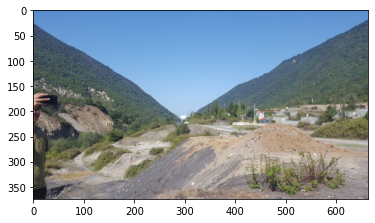

In [126]:
plt.imshow(data)

In [127]:
def find_nearest_cluster(data, index, mus):
    result = None
    result_cost = None
    at = data[index[0], index[1]]
    at0 = float(at[0])
    at1 = float(at[1])
    at2 = float(at[2])

    for idx in range(0, len(mus)):
        mu = mus[idx]
        dx = float(mu[0]) - at0
        dy = float(mu[1]) - at1
        dz = float(mu[2]) - at2
        cost = (dx*dx) + (dy*dy) + (dz * dz)
        if result_cost is None or (cost - result_cost) < -1e-5:
            result = idx
            result_cost = cost

    return result, result_cost

def assign_cluster(data, mus):
    xs = data.shape[0]
    ys = data.shape[1]
    result = []
    result_cost = 0
    
    for x in range(0, xs):
        result_row = []
        for y in range(0, ys):
            c, cost = find_nearest_cluster(data, [x, y], mus)
            result_row.append(c)
            result_cost = result_cost + cost
        result.append(result_row)

    return result, result_cost / (xs * ys)

def select_mus(data, c, mus, num_clusters):
    cluster_sum = [None] * num_clusters
    cluster_count = [0] * num_clusters
    xs = data.shape[0]
    ys = data.shape[1]
    
    for x in range(0, xs):
        for y in range(0, ys):
            selected_c = c[x][y]
            cluster_count[selected_c] = cluster_count[selected_c] + 1
            if cluster_sum[selected_c] is None:
                cluster_sum[selected_c] = np.array(data[x, y], np.uint64)
            else:
                cluster_sum[selected_c] = cluster_sum[selected_c] + np.array(data[x, y], np.uint64)

    result = []
    for i in range(0, num_clusters):
        if cluster_count[i] == 0:
            result.append(mus[i])
        else:
            result.append(np.array(np.floor(cluster_sum[i] / cluster_count[i]), np.uint8))
        
    return result, True

def iteration(data, mus):
    c, cost = assign_cluster(data, mus)
    mus, ok = select_mus(data, c, mus, len(mus))
    return c, mus, cost, ok

def pick_initial_mus(data, num_clusters):
    result = []
    for i in range(0, num_clusters):
        result.append(np.array([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)], np.uint8))
    return result

def solve_once(data, num_clusters, retry, sensitivity):
    c = None
    best_cost = None
    best_c = None
    try_count = 0
    
    mus = pick_initial_mus(data, num_clusters)
    
    while try_count <= retry:
        try_count = try_count + 1
        c, mus, cost, ok = iteration(data, mus)
        if not ok:
            return None, None, False
        if best_cost is None:
            best_cost = cost
            best_c = c
            try_count = 1
        else:
            if abs(best_cost - cost) < sensitivity:
                return best_c, best_cost, True
            if cost < best_cost:
                print(best_cost - cost)
                best_cost = cost
                best_c = c
                try_count = 1
                
    if best_cost is None:
        return None, None, False
    return best_c, best_cost, mus, True
                
def solve(data, num_clusters, retry, sensitivity):
    try_count = 0
    best_c = None
    best_cost = None
    best_mus = None
    while try_count <= retry:
        print('? solving using a random seed')
        try_count = try_count + 1
        c, cost, mus, ok = solve_once(data, num_clusters, retry, sensitivity)
        if not ok:
            num_clusters = num_clusters - 1
            try_count = 0
            continue
        if best_c is None:
            best_c = c
            best_cost = cost
            best_mus = mus
            try_count = 1
        elif abs(best_cost - cost) >= sensitivity and cost < best_cost:
            best_cost = cost
            best_c = c
            best_mus = mus
            try_count = 1
            
    return best_c, best_mus

def compress(data, num_colors):
    c, mus = solve(data, num_colors, 0, 1)
    result = []
    
    xs = data.shape[0]
    ys = data.shape[1]
    for x in range(0, xs):
        result_row = []
        for y in range(0, ys):
            result_row.append(mus[c[x][y]])
        result.append(result_row)
        
    return np.array(result)
    

? solving using a random seed


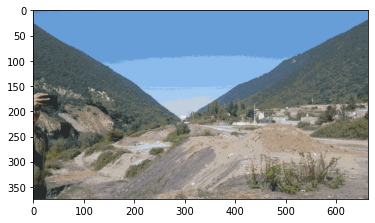

In [135]:
compressed = compress(data, 128)
plt.imshow(compressed)